In [3]:
import os

from tqdm import tqdm

import itertools
import warnings
warnings.filterwarnings('ignore')

from matplotlib import gridspec
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib import cm
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches

import datetime
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import STL


In [4]:
data_path = "../Datasets/"

In [5]:
NTL_data = pd.read_csv(data_path+"NTL_provincial.csv", parse_dates=True, index_col = 0)*10#.reset_index(drop=True)*10
NTL_data.astype(float)

def outlier_removal(dataframe):
    q_low = dataframe.quantile(0.05)
    q_hi  = dataframe.quantile(0.95)
    dataframe = dataframe[(dataframe < q_hi) & (dataframe > q_low)]
    return dataframe

NTL_data = outlier_removal(NTL_data)
NTL_data = NTL_data.interpolate(method='linear', limit_direction='both')
NTL_data
# NTL_data['Leyte']

Iloilo       Antique         Capiz         Aklan  \
date                                                                  
2012-01-19   73487.074510  25216.913725  19308.235294  14627.584314   
2012-01-20   73487.074510  25216.913725  19308.235294  14627.584314   
2012-01-21   73487.074510  16195.047059  19308.235294  14627.584314   
2012-01-22   77170.901961  17509.341176  19308.235294  14627.584314   
2012-01-23   80854.729412  18823.635294  19308.235294  14627.584314   
...                   ...           ...           ...           ...   
2024-12-22  131963.556863  27357.905882  34897.090196  28020.105882   
2024-12-23  132050.666667  27356.741176  34889.584314  28034.862745   
2024-12-24  131947.129412  27345.639216  34884.439216  28050.560784   
2024-12-25  131955.713725  27358.270588  34892.439216  28036.082353   
2024-12-26  131937.360784  27355.247059  34869.776471  27979.576471   

               Guimaras  Negros Occidental  Negros Oriental         Samar  \
date                                                                        
2012-01-19  4799.678431       99064.192157     42485.839216  21656.313725   
2012-01-20  4799.678431       99064.192157     42485.839216  38766.662745   
2012-01-21  4799.678431       99064.192157     45108.560784  14359.725490   
2012-01-22  3042.862745      107024.138824     43553.050980  16640.929412   
2012-01-23  3086.324183      114984.085490     43672.253595  42713.345098   
...                 ...                ...              ...           ...   
2024-12-22  7421.517647      178244.984314     64202.290196  25808.427451   
2024-12-23  7450.301961      178359.635294     64393.584314  55835.831373   
2024-12-24  7427.313725      178251.917647     64367.639216  28886.654902   
2024-12-25  7424.611765      178247.725490     61808.552941  35181.017647   
2024-12-26  7424.286275      178247.192157     63965.474510  41475.380392   

            Eastern Samar  Northern Samar         Leyte  Southern Leyte  \
date                                                                      
2012-01-19   24806.525490    14512.356863  57063.121569     8679.635294   
2012-01-20   24806.525490    14512.356863  57063.121569     8679.635294   
2012-01-21   24806.525490    20957.549020  80784.411765    10146.709804   
2012-01-22   27364.367059    21218.061176  52100.894118    10954.414902   
2012-01-23   29922.208627    21478.573333  50388.549020    11762.120000   
...                   ...             ...           ...             ...   
2024-12-22   26209.196078    24532.376471  95696.207843    13240.478431   
2024-12-23   26200.066667    24528.968627  95828.019608    13244.513725   
2024-12-24   26202.047059    24535.756863  95620.376471    13249.105882   
2024-12-25   26196.992157    24533.345098  95652.717647    13238.396078   
2024-12-26   26196.364706    24519.266667  95713.639216    13241.937255   

                     Cebu         Bohol  
date                                     
2012-01-19  248979.886274  32773.301961  
2012-01-20  248979.886274  32773.301961  
2012-01-21  248979.886274  38964.603922  
2012-01-22  195750.937255  38078.130532  
2012-01-23  196613.020588  37191.657143  
...                   ...           ...  
2024-12-22  369247.866667  57393.431373  
2024-12-23  369504.764706  57956.756863  
2024-12-24  369313.886274  57970.062745  
2024-12-25  369234.419608  54991.431373  
2024-12-26  369083.768627  57098.235294  

[4678 rows x 14 columns]

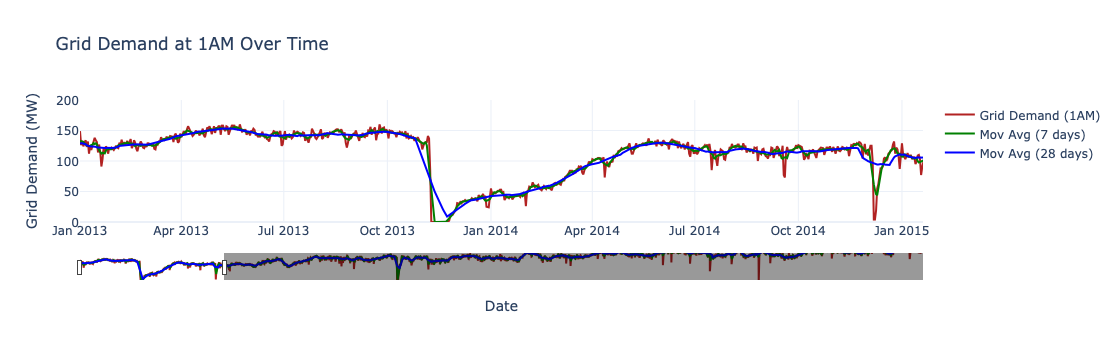

In [14]:
# Load the CSV and skip the first two rows (metadata/header issues)
df = pd.read_csv(data_path + "NGCP Hourly Demand.csv", skiprows=2)


df.columns = ['Date', 'Coincident Peak', 'Hour No'] + [str(i) for i in range(1, 25)]
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
df_1am = df[['Date', '1']].rename(columns={'1': 'Grid_1AM_MW'})
# df_1am = df_1am.loc['2013-01-01':'2023-12-31', "Grid_1AM_MW"]

# Plot time series
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_1am['Date'],
    y=df_1am['Grid_1AM_MW'],
    mode='lines',
    name='Grid Demand (1AM)',
    line=dict(color='firebrick')
))


fig.add_trace(go.Scatter(
    x=df_1am['Date'],
    y=df_1am['Grid_1AM_MW'].rolling(window=7, center=True, min_periods=1).mean(),
    mode='lines',
    name='Mov Avg (7 days)',
    line=dict(color='green'),
))

fig.add_trace(go.Scatter(
    x=df_1am['Date'],
    y=df_1am['Grid_1AM_MW'].rolling(window=28, center=True, min_periods=1).mean(),
    mode='lines',
    name='Mov Avg (28 days)',
    line=dict(color='blue'),
))


fig.update_layout(
    title='Grid Demand at 1AM Over Time',
    xaxis_title='Date',
    yaxis_title='Grid Demand (MW)',
    template='plotly_white',
    xaxis=dict(
        rangeslider=dict(visible=True),
        type="date"
    ),
    height = 400
)

fig.update_layout(yaxis_range=[0, 200]) # Using update_layout

fig.show()

In [5]:
NTL_subset = NTL_data[['Leyte', 'Samar']].reset_index().rename(columns={'index': 'Date'})#.dropna()
# NTL_subset.set_index('Date')

trend_df = pd.DataFrame(index=NTL_data.index)
seasonal_df = pd.DataFrame(index=NTL_data.index)

for col in ['Leyte', 'Samar']:
    series = NTL_data[col].dropna()
    decomposition = sm.tsa.seasonal_decompose(series, model='additive', period=4)
    trend_df[col] = decomposition.trend
    seasonal_df[col] = decomposition.seasonal

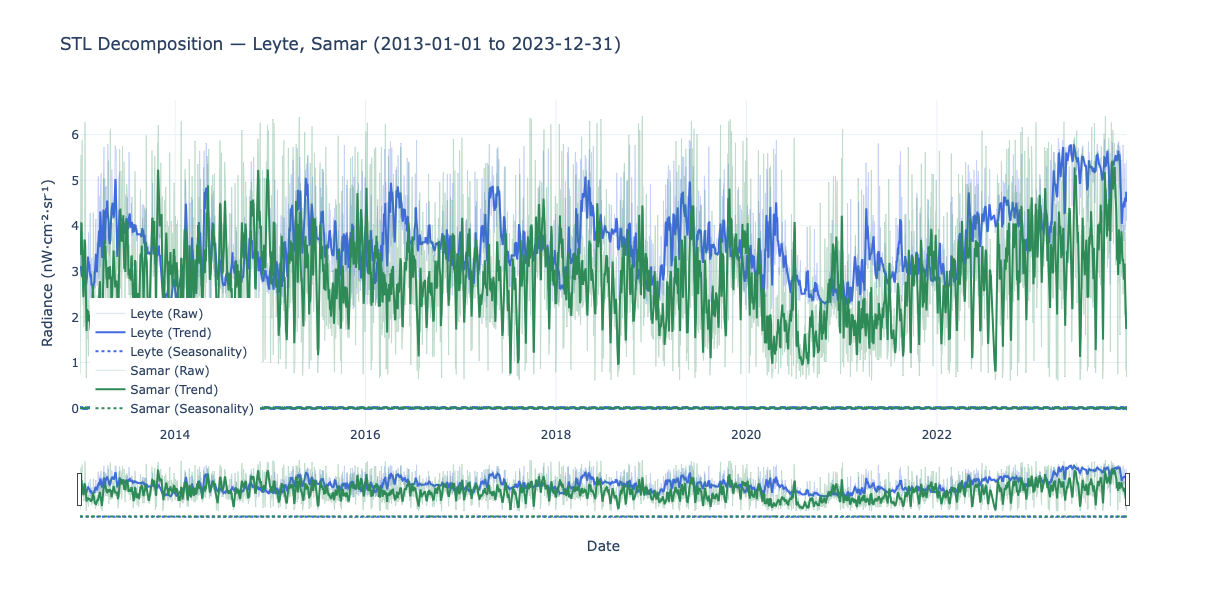

In [149]:
import pandas as pd
import statsmodels.api as sm
import plotly.graph_objects as go

def plot_stl_decomposition(NTL_data, columns=['Leyte', 'Samar'], start='2013-01-01', end='2023-12-31', period=7):
    # Trim date range
    NTL_trimmed = NTL_data.loc[start:end, columns]
    
    # Initialize containers
    trend_df = pd.DataFrame(index=NTL_trimmed.index)
    seasonal_df = pd.DataFrame(index=NTL_trimmed.index)

    # Decompose each column
    for col in columns:
        series = NTL_trimmed[col].dropna()
        decomposition = sm.tsa.seasonal_decompose(series, model='additive', period=period)
        trend_df[col] = decomposition.trend
        seasonal_df[col] = decomposition.seasonal

    # Plot
    fig = go.Figure()

    for col, color in zip(columns, ['royalblue', 'seagreen']):
        fig.add_trace(go.Scatter(x=NTL_trimmed.index, y=NTL_trimmed[col], name=f'{col} (Raw)',
                                 line=dict(color=color, width=1), opacity=0.3))
        fig.add_trace(go.Scatter(x=trend_df.index, y=trend_df[col], name=f'{col} (Trend)',
                                 line=dict(color=color, width=2)))
        fig.add_trace(go.Scatter(x=seasonal_df.index, y=seasonal_df[col], name=f'{col} (Seasonality)',
                                 line=dict(color=color, dash='dot')))

    fig.update_layout(
        title=f'STL Decomposition — {", ".join(columns)} ({start} to {end})',
        xaxis_title='Date',
        yaxis_title='Radiance (nW·cm⁻²·sr⁻¹)',
        template='plotly_white',
        xaxis=dict(rangeslider=dict(visible=True), type='date'),
        legend=dict(x=0.01, y=0.01),
        height = 600
    )

    return trend_df, seasonal_df, fig

trend, seasonal, fig = plot_stl_decomposition(NTL_data, period=7)
fig.show()

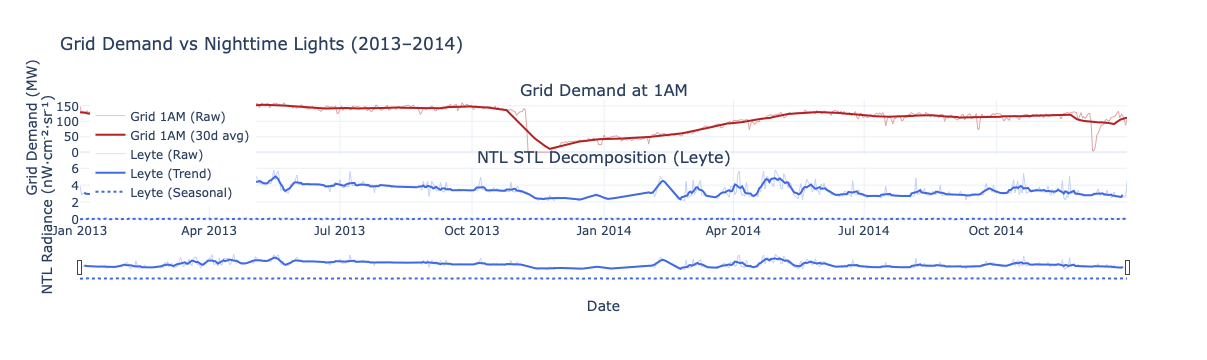

In [147]:
import pandas as pd
import statsmodels.api as sm
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Load Grid Demand Data ---
df = pd.read_csv(data_path + "NGCP Hourly Demand.csv", skiprows=2)
df.columns = ['Date', 'Coincident Peak', 'Hour No'] + [str(i) for i in range(1, 25)]
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
df_1am = df[['Date', '1']].rename(columns={'1': 'Grid_1AM_MW'})

# --- Trim for date range ---
df_1am = df_1am[(df_1am['Date'] >= '2013-01-01') & (df_1am['Date'] <= '2014-12-31')]

# --- Load and decompose NTL data ---
NTL_data_trimmed = NTL_data[['Leyte', 'Samar']].loc['2013-01-01':'2014-12-31']

trend_df = pd.DataFrame(index=NTL_data_trimmed.index)
seasonal_df = pd.DataFrame(index=NTL_data_trimmed.index)

for col in ['Leyte', 'Samar']:
    series = NTL_data_trimmed[col].dropna()
    decomposition = sm.tsa.seasonal_decompose(series, model='additive', period=7)
    trend_df[col] = decomposition.trend
    seasonal_df[col] = decomposition.seasonal

# --- Create Subplots ---
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    subplot_titles=["Grid Demand at 1AM", "NTL STL Decomposition (Leyte)"],
    vertical_spacing=0.1
)

# --- Grid Demand Plot ---
fig.add_trace(go.Scatter(x=df_1am['Date'], y=df_1am['Grid_1AM_MW'],
                         name='Grid 1AM (Raw)', line=dict(color='firebrick', width=1), opacity=0.4),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_1am['Date'],
                         y=df_1am['Grid_1AM_MW'].rolling(window=30, center=True, min_periods=1).mean(),
                         name='Grid 1AM (30d avg)', line=dict(color='firebrick', width=2)),
              row=1, col=1)

# --- NTL Trend + Seasonal ---
for col, color in zip(['Leyte'], ['royalblue', 'seagreen']):
    fig.add_trace(go.Scatter(x=NTL_data_trimmed.index, y=NTL_data_trimmed[col], name=f'{col} (Raw)',
                             line=dict(color=color, width=1), opacity=0.3), row=2, col=1)
    fig.add_trace(go.Scatter(x=trend_df.index, y=trend_df[col], name=f'{col} (Trend)',
                             line=dict(color=color, width=2)), row=2, col=1)
    fig.add_trace(go.Scatter(x=seasonal_df.index, y=seasonal_df[col], name=f'{col} (Seasonal)',
                             line=dict(color=color, dash='dot')), row=2, col=1)

# --- Layout ---
fig.update_layout(
    height=800,
    title='Grid Demand vs Nighttime Lights (2013–2014)',
    template='plotly_white',
    xaxis2=dict(title='Date', rangeslider=dict(visible=True)),
    yaxis1=dict(title='Grid Demand (MW)'),
    yaxis2=dict(title='NTL Radiance (nW·cm⁻²·sr⁻¹)'),
    legend=dict(x=0.01, y=0.99)
)

fig.show()

<Axes: >

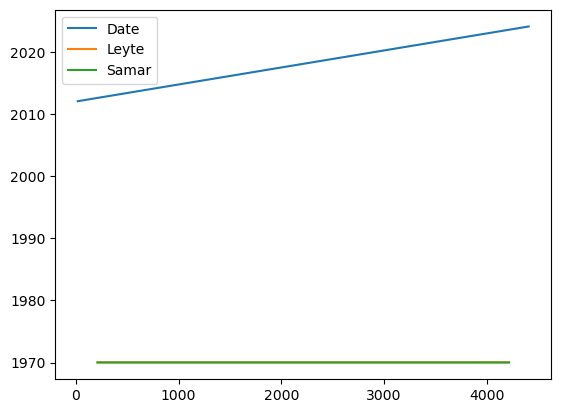

In [111]:
NTL_STL_prov['Trend'].plot()

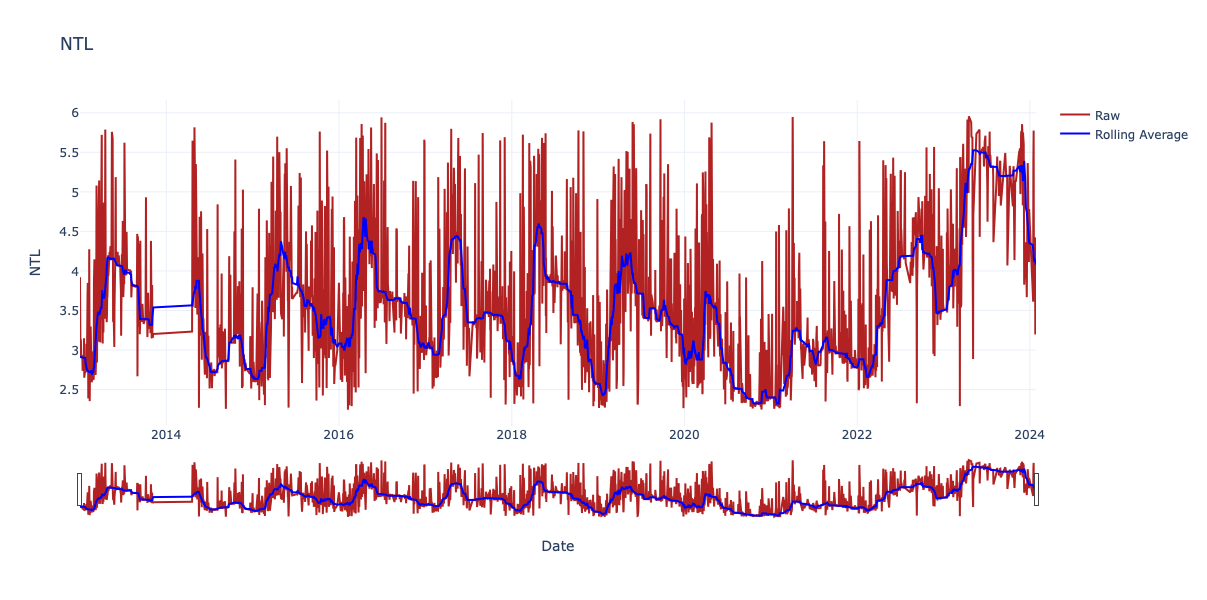

In [91]:
NTL_subset = NTL_data[['Leyte', 'Samar']].reset_index().rename(columns={'index': 'Date'})
NTL_subset['Date'] = pd.to_datetime(NTL_subset['Date'])

# Step 3: Merge datasets on Date
merged_df = pd.merge(NTL_subset, df_1am, on='Date', how='inner')

# --- Quantile filtering ---
for col in ['Leyte', 'Samar', 'Grid_1AM_MW']:
    q_low = merged_df[col].quantile(0.05)
    q_high = merged_df[col].quantile(0.95)
    merged_df = merged_df[merged_df[col].between(q_low, q_high)]

# --- Normalization ---
for col in ['Leyte', 'Samar', 'Grid_1AM_MW']:
    min_val = merged_df[col].min()
    max_val = merged_df[col].max()
    merged_df[col + '_norm'] = (merged_df[col] - min_val) / (max_val - min_val)


# Plot time series
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=merged_df['Date'],
    y=merged_df['Leyte'],
    mode='lines',
    name='Raw',
    line=dict(color='firebrick')
))

fig.add_trace(go.Scatter(
    x=merged_df['Date'],
    y=merged_df['Leyte'].rolling(window=30, center=True, min_periods=1).median(),
    mode='lines',
    name='Rolling Average',
    line=dict(color='blue')
))


fig.update_layout(
    title='NTL',
    xaxis_title='Date',
    yaxis_title='NTL',
    template='plotly_white',
    xaxis=dict(
        rangeslider=dict(visible=True),
        type="date"
    ),
    height = 600
)
fig.show()


# # --- 7-day moving average for NTL ---
# merged_df['Leyte_7d'] = merged_df['Leyte_norm'].rolling(7, center=True, min_periods=1).mean()
# merged_df['Samar_7d'] = merged_df['Samar_norm'].rolling(7, center=True, min_periods=1).mean()


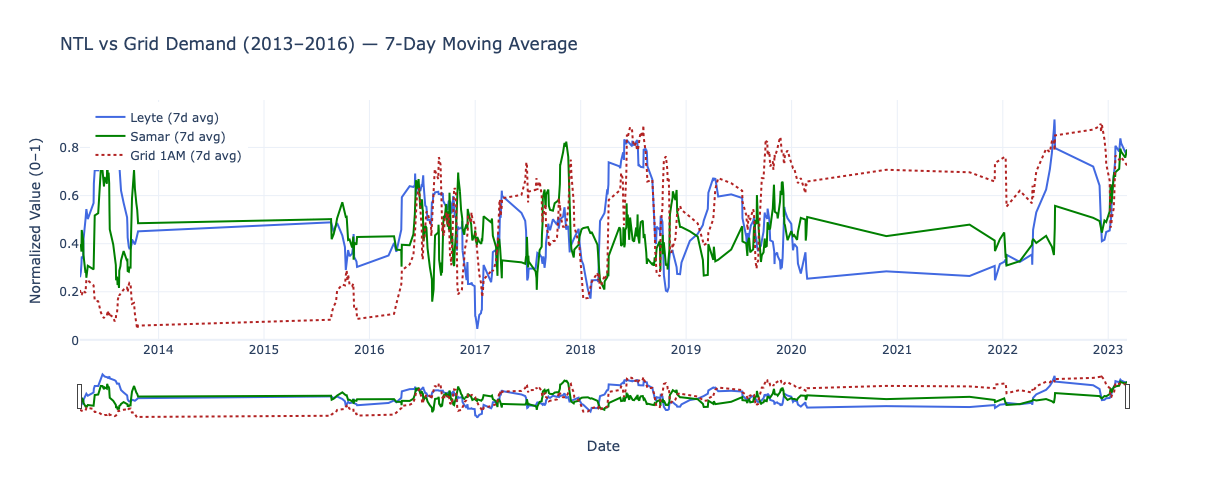

In [80]:
window = 7

# Quantile filtering (5–95%)
for col in ['Leyte', 'Samar', 'Grid_1AM_MW']:
    q_low, q_high = merged_df[col].quantile([0.05, 0.95])
    merged_df = merged_df[merged_df[col].between(q_low, q_high)]

# Normalize
for col in ['Leyte', 'Samar', 'Grid_1AM_MW']:
    min_val = merged_df[col].min()
    max_val = merged_df[col].max()
    merged_df[col + '_norm'] = (merged_df[col] - min_val) / (max_val - min_val)

# Moving average (no interpolation)
merged_df['Leyte_rolling'] = merged_df['Leyte_norm'].rolling(window=window, center=True, min_periods=1).mean()
merged_df['Samar_rolling'] = merged_df['Samar_norm'].rolling(window=window, center=True, min_periods=1).mean()
merged_df['Grid_rolling'] = merged_df['Grid_1AM_MW_norm'].rolling(window=window, center=True, min_periods=1).mean()

# Plot
fig = go.Figure()

# # Raw (faded)
# fig.add_trace(go.Scatter(x=merged_df['Date'], y=merged_df['Leyte_norm'], name='Leyte (raw)',
#                          line=dict(color='royalblue', width=1), opacity=0.3))
# fig.add_trace(go.Scatter(x=merged_df['Date'], y=merged_df['Samar_norm'], name='Samar (raw)',
#                          line=dict(color='green', width=1), opacity=0.3))
# fig.add_trace(go.Scatter(x=merged_df['Date'], y=merged_df['Grid_1AM_MW_norm'], name='Grid 1AM (raw)',
#                          line=dict(color='firebrick', width=1, dash='dot'), opacity=0.3))

# Smoothed
fig.add_trace(go.Scatter(x=merged_df['Date'], y=merged_df['Leyte_rolling'], name=f'Leyte ({window}d avg)',
                         line=dict(color='royalblue', width=2)))
fig.add_trace(go.Scatter(x=merged_df['Date'], y=merged_df['Samar_rolling'], name=f'Samar ({window}d avg)',
                         line=dict(color='green', width=2)))
fig.add_trace(go.Scatter(x=merged_df['Date'], y=merged_df['Grid_rolling'], name=f'Grid 1AM ({window}d avg)',
                         line=dict(color='firebrick', width=2, dash='dot')))

fig.update_layout(
    title=f'NTL vs Grid Demand (2013–2016) — {window}-Day Moving Average',
    xaxis_title='Date',
    yaxis_title='Normalized Value (0–1)',
    template='plotly_white',
    xaxis=dict(rangeslider=dict(visible=True), type='date'),
    legend=dict(x=0.01, y=0.99),
    height = 500
)

fig.show()

In [48]:
merged_df = merged_df.rename(columns={'Leyte': 'NTL'})
merged_df

NTL  Grid_1AM_MW
Date                             
2013-01-01  3.920865        149.0
2013-01-02  2.914705        121.0
2013-01-03  2.912419        123.0
2013-01-04  3.141116        139.0
2013-01-05  3.105896        146.0
...              ...          ...
2024-01-08  3.838707        203.0
2024-01-09  3.135751        226.0
2024-01-10  4.693074        252.0
2024-01-11  8.215627        235.0
2024-01-12  4.123234        213.0

[1596 rows x 2 columns]

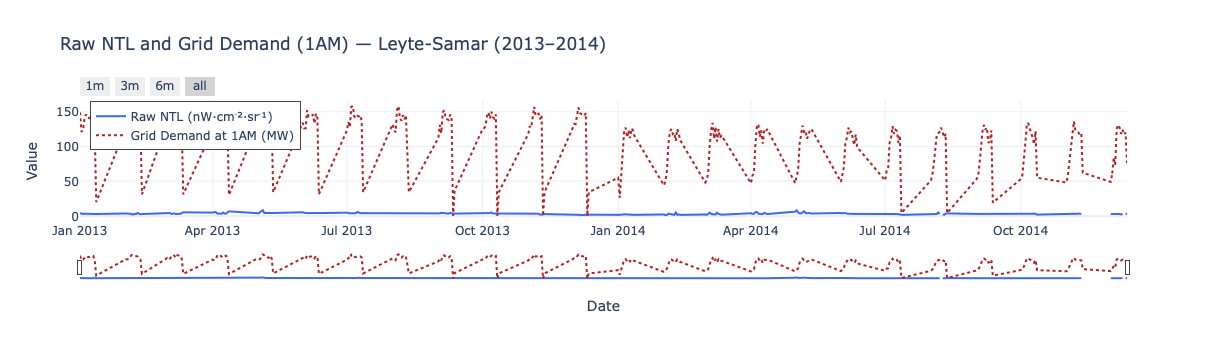

In [55]:
fig = go.Figure()

# Add raw NTL trace
fig.add_trace(go.Scatter(
    x=storm_df['Date'], y=storm_df['NTL'],
    mode='lines', name='Raw NTL (nW·cm⁻²·sr⁻¹)',
    line=dict(color='royalblue', width=2)
))

# Add raw Grid Demand trace
fig.add_trace(go.Scatter(
    x=storm_df['Date'], y=storm_df['Grid_1AM_MW'],
    mode='lines', name='Grid Demand at 1AM (MW)',
    line=dict(color='firebrick', width=2, dash='dot')
))

# Add slider and layout
fig.update_layout(
    title='Raw NTL and Grid Demand (1AM) — Leyte-Samar (2013–2014)',
    xaxis_title='Date',
    yaxis_title='Value',
    template='plotly_white',
    legend=dict(x=0.01, y=0.99, borderwidth=0.5),
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=3, label="3m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

fig.show()

In [44]:
storm_df

Date     Leyte  Grid_1AM_MW
0   2013-01-01  3.920865        149.0
1   2013-01-02  2.914705        121.0
2   2013-01-03  2.912419        123.0
3   2013-01-04  3.141116        139.0
4   2013-01-05  3.105896        146.0
..         ...       ...          ...
283 2014-12-08  2.136072        118.0
284 2014-12-09  2.865676        124.0
285 2014-12-10       NaN        117.0
286 2014-12-11  3.547696        120.0
287 2014-12-12  2.769351         76.0

[288 rows x 3 columns]

<Axes: xlabel='Date'>

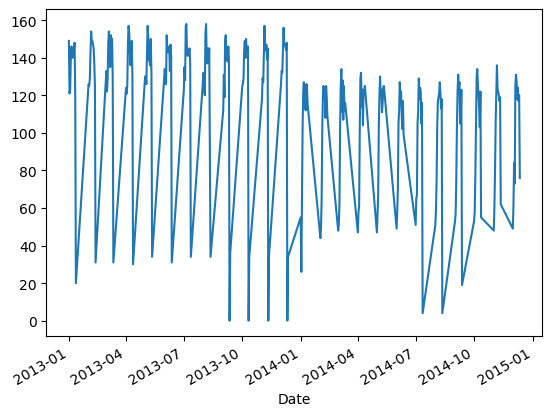

In [57]:
storm_df['Grid_1AM_MW'].plot()

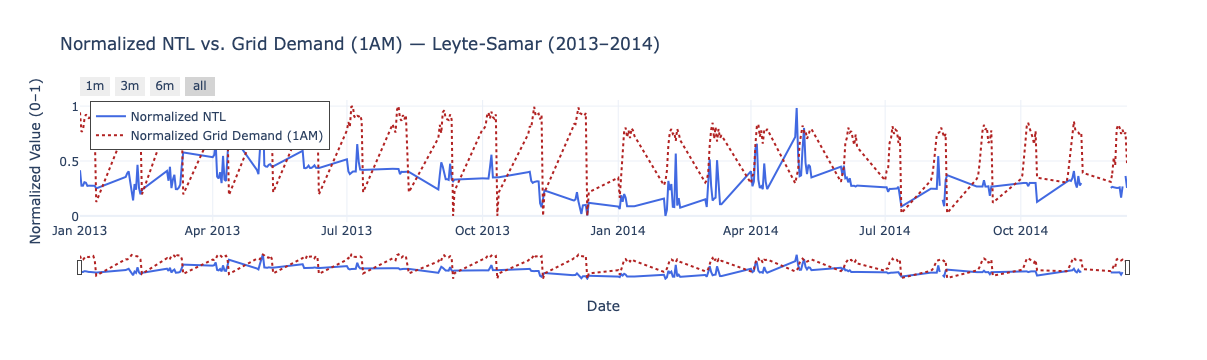

In [54]:
storm_df = merged_df.reset_index()

storm_df = merged_df[(merged_df.index >= '2013-01-01') & (merged_df.index <= '2014-12-31')].copy()
storm_df['Date'] = storm_df.index  # add back as column for plotting

# Normalize
storm_df['NTL_norm'] = (storm_df['NTL'] - storm_df['NTL'].min()) / (storm_df['NTL'].max() - storm_df['NTL'].min())
storm_df['Grid_1AM_MW_norm'] = (storm_df['Grid_1AM_MW'] - storm_df['Grid_1AM_MW'].min()) / (storm_df['Grid_1AM_MW'].max() - storm_df['Grid_1AM_MW'].min())

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=storm_df['Date'], y=storm_df['NTL_norm'],
                         mode='lines', name='Normalized NTL',
                         line=dict(color='royalblue', width=2)))
fig.add_trace(go.Scatter(x=storm_df['Date'], y=storm_df['Grid_1AM_MW_norm'],
                         mode='lines', name='Normalized Grid Demand (1AM)',
                         line=dict(color='firebrick', width=2, dash='dot')))
fig.update_layout(
    title='Normalized NTL vs. Grid Demand (1AM) — Leyte-Samar (2013–2014)',
    xaxis_title='Date',
    yaxis_title='Normalized Value (0–1)',
    template='plotly_white',
    legend=dict(x=0.01, y=0.99, borderwidth=0.5),
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=3, label="3m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)
fig.show()